In [6]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import numpy as np 
import matplotlib.pyplot as plt 
import time
from skimage import io
import skimage.transform as tr
import warnings 
import copy
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [7]:
train_dir ='datasets/train/'
test_dir = 'datasets/test/'

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),       #  输入尺寸
    transforms.RandomCrop((224,224)),  #  裁剪尺寸
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.ColorJitter(
        brightness=(0.7,1.3),  # 明暗程度
        contrast=(0.7,1.3),    # 对比度
        saturation=(0.7,1.3),  # 饱和度
        hue=(-0.05,0.05)),     # 颜色
    transforms.ToTensor(),    # 数据转为张量并做归一化
    transforms.Normalize(   # 数据标准化
        mean = [.5,.5,.5],    # RGB均值
        std = [.5,.5,.5])      # RGB 方差  （可以使用经验值（查阅））
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),   # 输入尺寸（在预测中应遵循此尺寸）
    transforms.ToTensor(),         # 张量      
    transforms.Normalize(         # 标准化
        mean = [.5,.5,.5],
        std = [.5,.5,.5])
])

In [16]:
train_ds = torchvision.datasets.ImageFolder(
    train_dir,    # 导入训练文件夹路径
    transform=train_transform  # 数据处理与增强
)
test_ds = torchvision.datasets.ImageFolder(
    test_dir,     # 导入测试文件夹路径
    transform=test_transform   # 数据处理与增强

)
# 创建dl
BATCHSIZE = 50 # batch_size的批量尺寸
train_dl = torch.utils.data.DataLoader(
    train_ds,   # 将打包好的数据生成可迭代的batch_size个数的批量数据
    batch_size=BATCHSIZE,  # batch_size 值得选择应对照本机配置
    shuffle=True   # 打乱（必须打乱否则模型会识别顺序）
)
test_dl = torch.utils.data.DataLoader(
    test_ds,      
    batch_size=BATCHSIZE
)

In [17]:
model = torchvision.models.alexnet(pretrained=True)


In [18]:
model = torchvision.models.alexnet(pretrained=True)
# model.fc.out_features = 9
# 冻结 卷积基 操作
for param in model.features.parameters():
    param.requires_grad=False
# model.fc =nn.Linear(model.fc.in_features,9)
model.classifier[-1].out_features = 9
device =torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 模拟模型放入加速运算的GPU
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
exp_lr_scheduler= torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

cuda


In [19]:
def train(dataloader,model,loss_fn,optimizer):
    # acc 当前样本一共有多少个
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # 初始化loss值
    train_loss,correct = 0,0
    model.train()  # 模式为训练模式
    for X,y in dataloader:
        # 前向传播（推理）
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # 产生误差
        loss = loss_fn(pred,y)  # 返回平均误差
        # loss = torch.nn.functional.cross_entropy(pred, y)
        # 归零权重(固定写法)
        optimizer.zero_grad()
        # loss = torch.zeros(1, requires_grad=True)
        # 反向传递
        loss.backward()
        
        # 利用梯度下降优化参数
        optimizer.step()
        # # 放弃张量微分的追踪（小验证）
        with torch.no_grad():
            train_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    exp_lr_scheduler.step()
    lr_res = optimizer.state_dict()['param_groups'][0]['lr']  
    correct /= size        
    train_loss /= num_batches
    return train_loss,correct,lr_res

In [20]:
def test(dataloader,model):
    # acc 当前样本一共有多少个
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss,correct = 0,0
    model.eval()  # 推理模式
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size        
    test_loss /= num_batches
    return test_loss,correct

In [21]:
def fit(epochs,train_dl,test_dl,model,loss_fn,optimizer,
        exp_lr_scheduler=None):
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    for epoch in range(epochs):
        start  =  time.time()
        epoch_loss,epoch_acc,lr = train(dataloader=train_dl,model=model,loss_fn=loss_fn,optimizer=optimizer)
        epoch_test_loss,epoch_test_acc = test(dataloader=test_dl,model=model)
        end = time.time()
        times = end - start 
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)
        if exp_lr_scheduler:
            exp_lr_scheduler.step()
        # print('训练epoch{},训练集损失值:{:.2f},训练集的准确率:{:.2f}%,测试集损失值:{:.2f},测试集的准确率:{:.2f}%,消耗时间：{:.2f}s'.
        #       format(epoch+1,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100,times))
        print('训练epoch{},训练集损失值:{:.2f},训练集的准确率:{:.2f}%,测试集损失值:{:.2f},测试集的准确率:{:.2f}%,当前学习率：{}，消耗时间：{:.2f}s'.
                format(epoch+1,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100,lr,times))
        
    return train_loss,test_loss,train_acc,test_acc

In [22]:
res = fit(50,train_dl,test_dl,model,loss_fn,optimizer)

训练epoch1,训练集损失值:1.41,训练集的准确率:56.40%,测试集损失值:0.66,测试集的准确率:76.27%,当前学习率：0.0001，消耗时间：74.23s
训练epoch2,训练集损失值:0.87,训练集的准确率:69.45%,测试集损失值:0.55,测试集的准确率:80.04%,当前学习率：0.0001，消耗时间：70.46s
训练epoch3,训练集损失值:0.74,训练集的准确率:73.57%,测试集损失值:0.47,测试集的准确率:82.82%,当前学习率：0.0001，消耗时间：70.60s
训练epoch4,训练集损失值:0.66,训练集的准确率:76.60%,测试集损失值:0.41,测试集的准确率:85.21%,当前学习率：0.0001，消耗时间：71.56s
训练epoch5,训练集损失值:0.58,训练集的准确率:79.66%,测试集损失值:0.38,测试集的准确率:85.90%,当前学习率：0.0001，消耗时间：70.23s
训练epoch6,训练集损失值:0.54,训练集的准确率:81.04%,测试集损失值:0.34,测试集的准确率:87.68%,当前学习率：0.0001，消耗时间：70.54s
训练epoch7,训练集损失值:0.51,训练集的准确率:82.25%,测试集损失值:0.36,测试集的准确率:87.42%,当前学习率：0.0001，消耗时间：70.21s
训练epoch8,训练集损失值:0.48,训练集的准确率:83.32%,测试集损失值:0.32,测试集的准确率:88.33%,当前学习率：0.0001，消耗时间：70.21s
训练epoch9,训练集损失值:0.44,训练集的准确率:84.68%,测试集损失值:0.29,测试集的准确率:90.15%,当前学习率：0.0001，消耗时间：70.73s
训练epoch10,训练集损失值:0.41,训练集的准确率:85.55%,测试集损失值:0.30,测试集的准确率:89.80%,当前学习率：0.0001，消耗时间：70.44s
训练epoch11,训练集损失值:0.39,训练集的准确率:86.32%,测试集损失值:0.30,测试集的准确率:90.07%,当前学习率：0.0001，消耗时间：70.67s
训练epoch12,训练集损失值:0.37,训练集的准确率:

In [24]:
# print(f'device:{torch.cuda.get_device_name(0)}')
torch.save(model.state_dict(),'alexnet.pth')

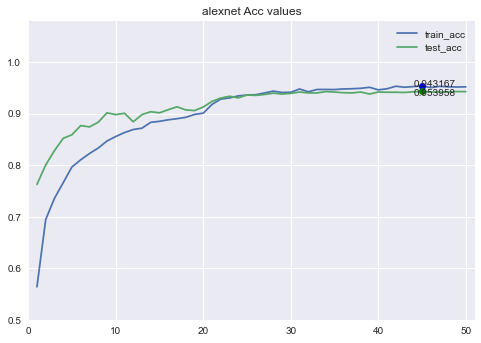

In [45]:
### 训练曲线可视化
# 准确率
train_loss = res[0]
test_loss = res[1]
train_acc = res[2]
test_acc = res[3]
train_acc_max_index = np.argmax(np.array(train_acc))
train_acc_max_value = round(train_acc[train_acc_max_index],6)
test_acc_max_index = np.argmax(np.array(test_acc))
test_acc_max_value = round(test_acc[test_acc_max_index],6)

s = train_acc_max_value
s_test = test_acc_max_value
plt.plot(range(1,51),train_acc,label='train_acc')
plt.plot(range(1,51),test_acc,label='test_acc')
plt.text(train_acc_max_index, train_acc_max_value-0.02, s)
plt.text(test_acc_max_index, test_acc_max_value+0.01, s_test)
plt.plot(train_acc_max_index+1,train_acc_max_value,'bo')
plt.plot(test_acc_max_index+1,test_acc_max_value,'go')
plt.title('alexnet Acc values')
plt.ylim(0.5,1.08)
plt.xlim(0,51)
plt.legend()
plt.savefig('alexnet_acc')

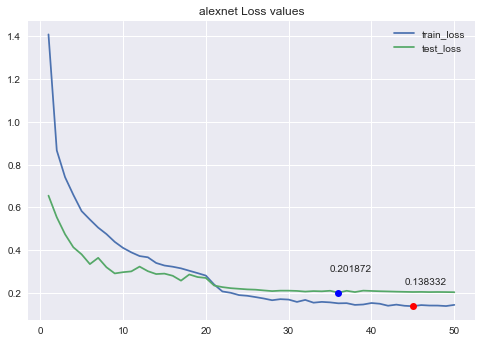

In [43]:
## 训练曲线可视化
# 损失值
train_loss_min_index = np.argmin(np.array(train_loss))
train_loss_min_value = round(train_loss[train_loss_min_index],6)
test_loss = torch.stack(test_loss).cpu().numpy()
test_loss_min_index = np.argmin(test_loss)
test_loss_min_value = round(test_loss[test_loss_min_index],6)

s = train_loss_min_value
s_test = test_loss_min_value
plt.plot(range(1,51),train_loss,label='train_loss')
plt.plot(range(1,51),test_loss,label='test_loss')
plt.text(train_loss_min_index, train_loss_min_value+0.1, s)
plt.text(test_loss_min_index, test_loss_min_value+0.1, s_test)
plt.plot(train_loss_min_index+1,train_loss_min_value,'ro')
plt.plot(test_loss_min_index+1,test_loss_min_value,'bo')
plt.title('alexnet Loss values')
plt.legend()

plt.savefig('alexnet_loss')